In [1]:
import scipy
import numpy as np
import tensorflow as tf

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16, 'savefig.dpi': 300, 'savefig.bbox': 'tight'})
results_dir = "../results/lj_cluster/"

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from energy_models.lennard_jones_cluster import LennardJonesCluster

In [5]:
from boltzmann_generator import BoltzmannGenerator

In [6]:
from sampling import MetropolisGauss, UmbrellaModel, UmbrellaSampling, HungarianMapper
from analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
model = LennardJonesCluster()

In [8]:
model.params

{'n_particles': 7, 'epsilon': 10.0, 'sigma': 1, 'k_origin': 15.0}

## Check drawing scripts and model functionality

### Check drawing and calculation of coordination number

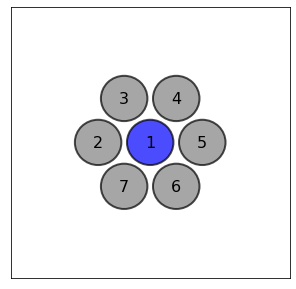

In [11]:
x0 = model.init_positions()
model.draw_config(x0, with_numbers=True, particle_colors={1: "blue"}, box_size=6)
plt.savefig(results_dir + "example_center.png")

In [12]:
print("Coordination number")
print("numpy:", model.coordination_number(x0, 1))
print("tensorflow:", model.coordination_number_tf(tf.convert_to_tensor(x0), 1))

Coordination number
numpy: [5.64449317]
tensorflow: tf.Tensor([5.64449317], shape=(1,), dtype=float64)


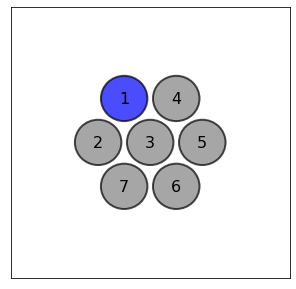

In [13]:
x1 = model.permute_particles(x0, [3, 2, 1, 4, 5, 6, 7])
model.draw_config(x1, particle_colors={1: "blue"}, with_numbers=True, box_size=6)
plt.savefig(results_dir + "example_surface.png")

In [14]:
print("Coordination number")
print("numpy:", model.coordination_number(x1, 1))
print("tensorflow:", model.coordination_number_tf(tf.convert_to_tensor(x1), 1))

Coordination number
numpy: [3.30293394]
tensorflow: tf.Tensor([3.30293394], shape=(1,), dtype=float64)


### Plot the switch function

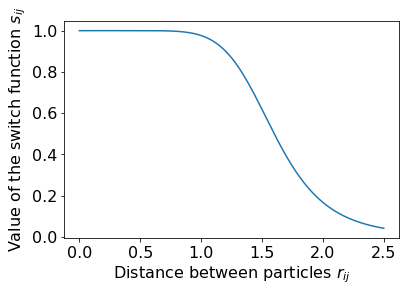

In [18]:
x = np.linspace(0, 2.5, 300)
y = model._switch_function(x)
plt.plot(x, y)
plt.xlabel("Distance between particles $r_{ij}$")
plt.ylabel("Value of the switch function $s_{ij}$")
plt.savefig(results_dir + "switch_function.png")

### Test interaction energy between particles

In [19]:
params_test_energy = LennardJonesCluster.default_params.copy()
params_test_energy["n_particles"] = 2
model_test_energy = LennardJonesCluster(params_test_energy)

(-13.0, 15.0)

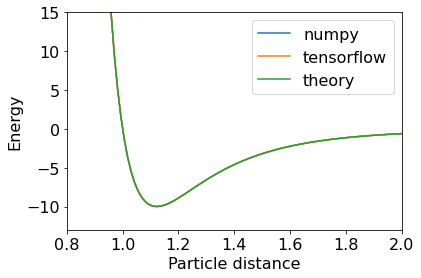

In [20]:
energies_np = []
energies_tf = []
x = np.linspace(0.8, 2, 100)

for distance in x:
    configuration = model_test_energy.init_positions(distance)
    energies_np.append(
        model_test_energy.LJ_energy(configuration)[0]
    )
    energies_tf.append(
        model_test_energy.LJ_energy_tf(tf.convert_to_tensor(configuration, dtype=tf.float32))[0].numpy()
    )

r = model.params["sigma"] / x
lj_interaction = 4 * model.params["epsilon"] * (r**12 - r**6)
                                                
plt.plot(x, energies_np, label="numpy")
plt.plot(x, energies_tf, label="tensorflow")
plt.plot(x, lj_interaction, label="theory")
plt.legend(loc="upper right")
plt.xlabel("Particle distance")
plt.ylabel("Energy")
plt.xlim(0.8, 2)
plt.ylim(-13, 15)

## Test how system reacts to the umbrella potential

In [53]:
# Plot statistics for an MCMC simulation
def plot_traj_data(trajectory, color="royalblue"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    rc_traj = model.coordination_number(trajectory)
    
    axes[0].hist(rc_traj, 50, alpha=1, color=color)
    axes[0].set_xlabel("Coordination number")
    
    axes[1].plot(rc_traj, color=color)
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Coordination number")
    
    axes[2].hist(model.energy(trajectory), 50, alpha=1, color=color)
    axes[2].set_xlabel("Energy")
    fig.tight_layout()

In [55]:
umbrella_model_1 = UmbrellaModel(model, model.coordination_number, 400, 4)

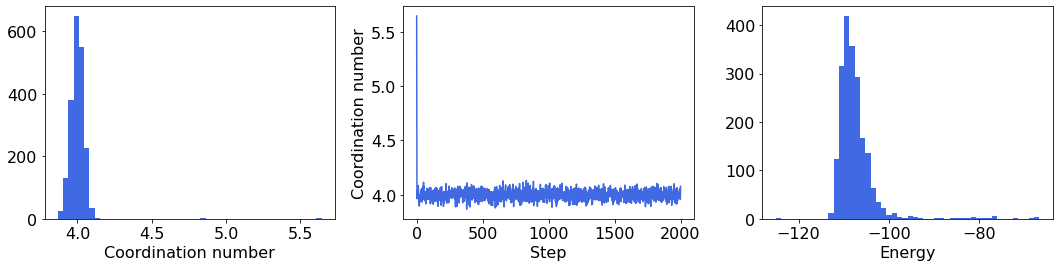

In [56]:
sigma = 0.025
sampler = MetropolisGauss(umbrella_model_1, model.init_positions(), sigma_metro=sigma, stride=50)
sampler.run(100000)
plot_traj_data(sampler.trajectory)

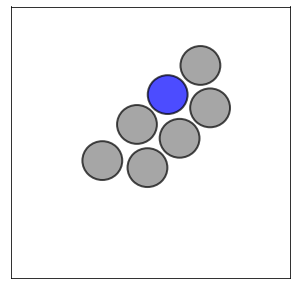

In [30]:
model.draw_config(sampler.trajectory[-1], particle_colors={1: "blue"})
plt.savefig(results_dir + "example_cn_4.png")

In [57]:
umbrella_model_2 = UmbrellaModel(model, model.coordination_number, 400, 4.8)

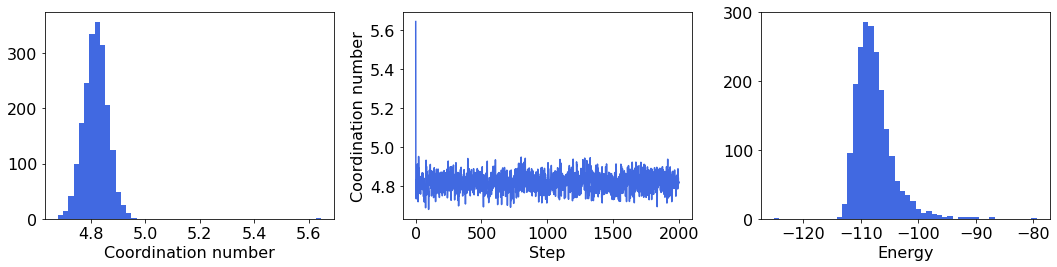

In [58]:
sampler = MetropolisGauss(umbrella_model_2, model.init_positions(), sigma_metro=sigma, stride=50)
sampler.run(100000)
plot_traj_data(sampler.trajectory)

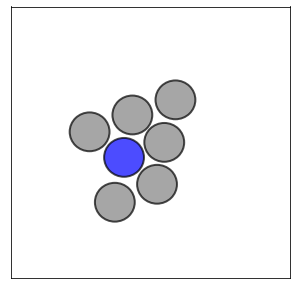

In [33]:
model.draw_config(sampler.trajectory[-1], particle_colors={1: "blue"})
plt.savefig(results_dir + "example_cn_4_8.png")

## Find out the best value of $\sigma_{\text{metro}}$

In [34]:
x0 = model.init_positions()
msd = []
sigmas = np.arange(0.005, 0.045, 0.001)
for sigma in sigmas:
    print("Sigma:", sigma)
    sampler = MetropolisGauss(model, x0, sigma_metro=sigma, burn_in=10000, stride=50)
    sampler.run(300000, verbose=50000)
    msd.append(np.mean((sampler.trajectory[1:] - sampler.trajectory[:-1])**2)) 

Sigma: 0.005
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.006
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.007
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.008
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.009000000000000001
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.01
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.011
Step 0 / 300000
Step 50000 / 300000
Step 100000 / 300000
Step 150000 / 300000
Step 200000 / 300000
Step 250000 / 300000
Sigma: 0.012
Step 0 / 300000
Step 50000 / 300000
Step 1

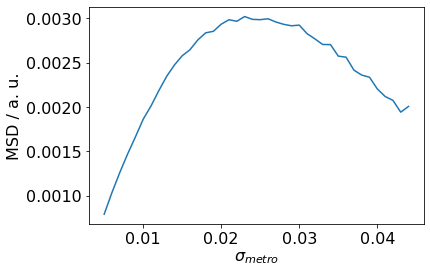

In [36]:
plt.plot(sigmas, msd)
plt.xlabel("$\sigma_{metro}$")
plt.ylabel("MSD / a. u.")
plt.savefig(results_dir + "MSD_vs_sigma_metro.png")

## Calculate reference free-energy profile with umbrella sampling
If data are already saved, we can load them and skip this section.

In [37]:
us_data = np.load('../resources/lj_cluster_us_data.npz', allow_pickle=True)

umbrella_positions = us_data["us_positions"]
umbrella_free_energy = us_data["us_free_energy"]

mbar_positions = us_data["mbar_positions"]
mbar_free_energy = us_data["mbar_free_energy"]

In [38]:
sigma = 0.025

<AxesSubplot:>

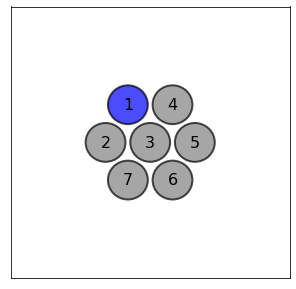

In [39]:
x0 = model.init_positions()
x0 = model.permute_particles(x0, [3, 2, 1, 4, 5, 6, 7])
model.draw_config(x0, particle_colors={1: "blue"}, with_numbers=True)

In [40]:
# Umbrella sampling
sampler = MetropolisGauss(model, x0, sigma_metro=sigma, burn_in=20000, stride=10)
us = UmbrellaSampling(model, sampler, model.coordination_number, x0, 60, 400, 2.7, 6, forward_backward=True)
us.run(n_steps=100000, verbose=True)
umbrella_positions = us.umbrella_positions
umbrella_free_energy = us.umbrella_free_energies()

Umbrella 1 / 120
Umbrella 2 / 120
Umbrella 3 / 120
Umbrella 4 / 120
Umbrella 5 / 120
Umbrella 6 / 120
Umbrella 7 / 120
Umbrella 8 / 120
Umbrella 9 / 120
Umbrella 10 / 120
Umbrella 11 / 120
Umbrella 12 / 120
Umbrella 13 / 120
Umbrella 14 / 120
Umbrella 15 / 120
Umbrella 16 / 120
Umbrella 17 / 120
Umbrella 18 / 120
Umbrella 19 / 120
Umbrella 20 / 120
Umbrella 21 / 120
Umbrella 22 / 120
Umbrella 23 / 120
Umbrella 24 / 120
Umbrella 25 / 120
Umbrella 26 / 120
Umbrella 27 / 120
Umbrella 28 / 120
Umbrella 29 / 120
Umbrella 30 / 120
Umbrella 31 / 120
Umbrella 32 / 120
Umbrella 33 / 120
Umbrella 34 / 120
Umbrella 35 / 120
Umbrella 36 / 120
Umbrella 37 / 120
Umbrella 38 / 120
Umbrella 39 / 120
Umbrella 40 / 120
Umbrella 41 / 120
Umbrella 42 / 120
Umbrella 43 / 120
Umbrella 44 / 120
Umbrella 45 / 120
Umbrella 46 / 120
Umbrella 47 / 120
Umbrella 48 / 120
Umbrella 49 / 120
Umbrella 50 / 120
Umbrella 51 / 120
Umbrella 52 / 120
Umbrella 53 / 120
Umbrella 54 / 120
Umbrella 55 / 120
Umbrella 56 / 120
U

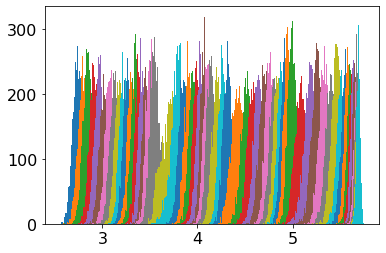

In [41]:
for umbrella_dtraj in us.rc_trajectories[:60]:
    plt.hist(umbrella_dtraj, 100);

In [42]:
mbar_positions, mbar_free_energy = us.mbar(2.7, 6, 60, max_error=1e-03)

../sampling.py:300: RuntimeWarning: divide by zero encountered in log
  F = -np.log(F)


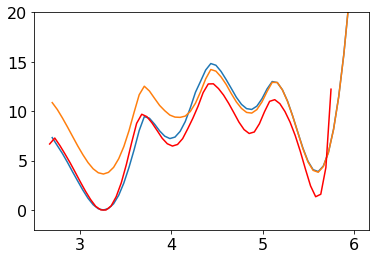

In [43]:
plt.plot(umbrella_positions[:60], umbrella_free_energy[:60] - umbrella_free_energy.min())
plt.plot(umbrella_positions[60:], umbrella_free_energy[60:] - umbrella_free_energy.min())
plt.ylim(-2, 20)
plt.plot(mbar_positions, mbar_free_energy - mbar_free_energy.min(), color='red')

In [44]:
us_data = {}
# Profile calculated using BAR between every two consecutive windows.
us_data["us_positions"] = umbrella_positions
us_data["us_free_energy"] = umbrella_free_energy
# Profile calculated using MBAR.
us_data["mbar_positions"] = mbar_positions
us_data["mbar_free_energy"] = mbar_free_energy

In [45]:
# Save US data.
np.savez_compressed('../resources/lj_cluster_us_data.npz', **us_data)

# Sample training and validation datasets

### Marked particle in the center

In [59]:
sigma = 0.025

<AxesSubplot:>

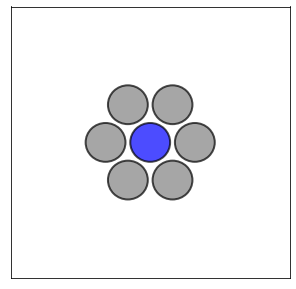

In [60]:
x_center = model.init_positions()
model.draw_config(x_center, particle_colors={1: "blue"})

In [61]:
sampler = MetropolisGauss(model, x_center, sigma_metro=sigma, burn_in=10000, stride=20)
sampler.run(510000)
traj_center_train = sampler.trajectory

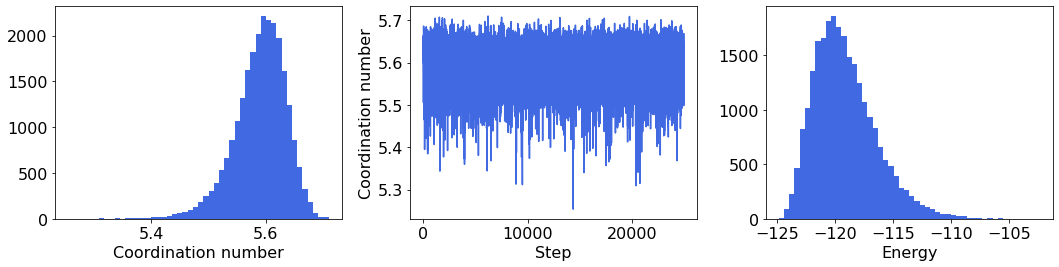

In [62]:
plot_traj_data(traj_center_train)
plt.savefig(results_dir + "mcmc_simulation_center.png")

Sample again for validation dataset.

In [63]:
sampler = MetropolisGauss(model, x_center, sigma_metro=sigma, burn_in=10000, stride=20)
sampler.run(510000)
traj_center_test = sampler.trajectory

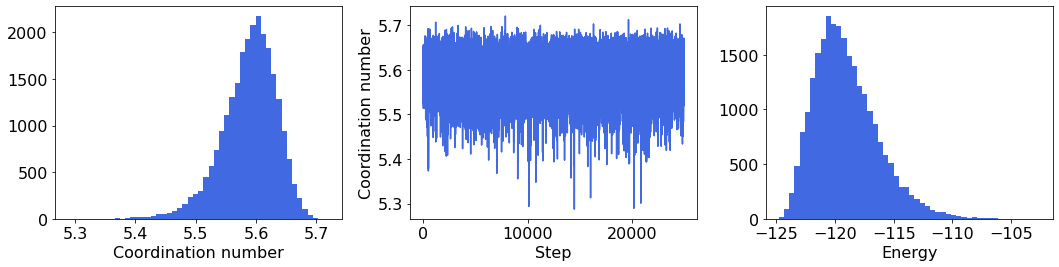

In [64]:
plot_traj_data(traj_center_test)

### Marked particle at the surface

<AxesSubplot:>

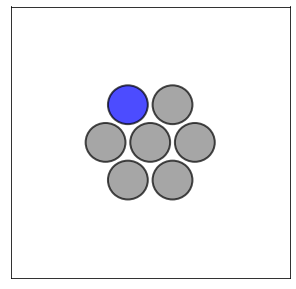

In [65]:
x_surface = model.init_positions()
x_surface = model.permute_particles(x_surface, [3,2,1,4,5,6,7])
model.draw_config(x_surface, particle_colors={1: "blue"})

In [66]:
sampler = MetropolisGauss(model, x_surface, sigma_metro=sigma, burn_in=10000, stride=20)
sampler.run(510000)
traj_surface_train = sampler.trajectory

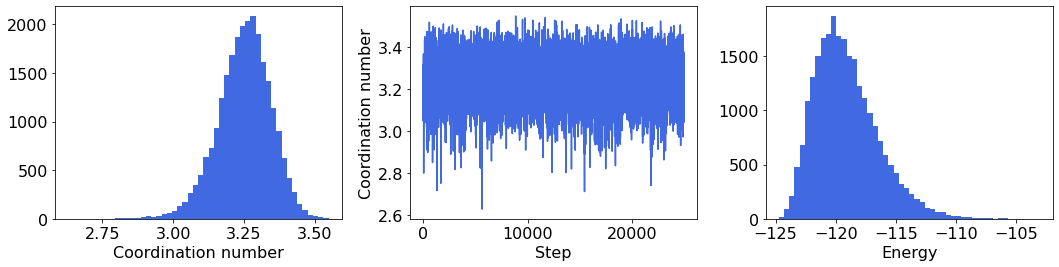

In [67]:
plot_traj_data(traj_surface_train)
plt.savefig(results_dir + "mcmc_simulation_surface.png")

Sample again for validation dataset.

In [68]:
sampler = MetropolisGauss(model, x_surface, sigma_metro=sigma, burn_in=10000, stride=20)
sampler.run(510000)
traj_surface_test = sampler.trajectory

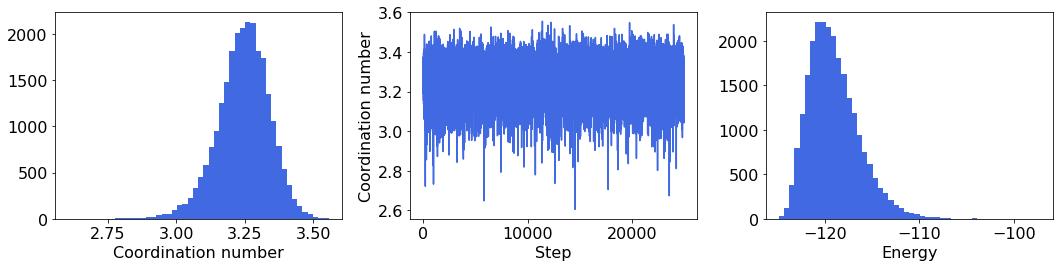

In [69]:
plot_traj_data(traj_surface_test)

### Use Hungarian mapper to remove particle exchanges
- Only first (blue) particle, whose coordination number is used as RC, does not participate in mapping.
- Configuration which is obtained from transition center state --> surface state is used as reference for surface configurations.

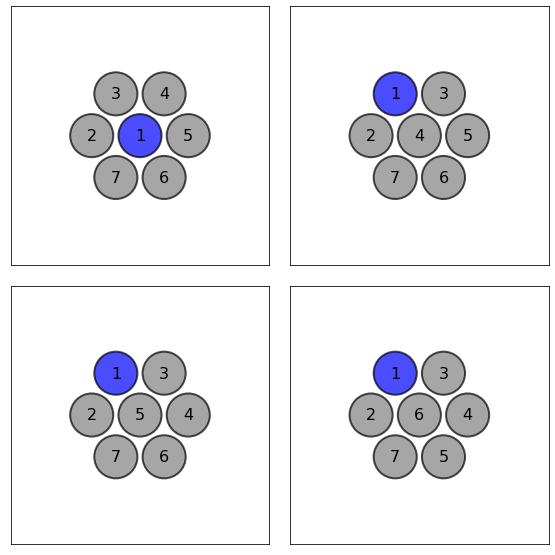

In [71]:
x_surface_after_transition_1 = model.permute_particles(x_center, [4, 2, 1, 3, 5, 6, 7])
x_surface_after_transition_2 = model.permute_particles(x_center, [5, 2, 1, 3, 4, 6, 7])
x_surface_after_transition_3 = model.permute_particles(x_center, [6, 2, 1, 3, 4, 5, 7])

plot_kwargs = {"with_numbers": True, "particle_colors": {1: "blue"}, "box_size": 6}
fig, axes = plt.subplots(2, 2, figsize=(8,8))
model.draw_config(x_center, axis=axes[0, 0], **plot_kwargs)
model.draw_config(x_surface_after_transition_1, axis=axes[0, 1], **plot_kwargs)
model.draw_config(x_surface_after_transition_2, axis=axes[1, 0], **plot_kwargs)
model.draw_config(x_surface_after_transition_3, axis=axes[1, 1], **plot_kwargs)
fig.tight_layout()
fig.savefig(results_dir + "reference_configurations.png")

In [72]:
mapper_center = HungarianMapper(x_center, dim=2)

mapper_surface_1 = HungarianMapper(x_surface_after_transition_1, dim=2)
mapper_surface_2 = HungarianMapper(x_surface_after_transition_2, dim=2)
mapper_surface_3 = HungarianMapper(x_surface_after_transition_3, dim=2)

In [73]:
traj_center_train_hungarian = mapper_center.map(traj_center_train)
traj_center_test_hungarian = mapper_center.map(traj_center_test)

N = 8000
traj_surface_train_1_hungarian = mapper_surface_1.map(traj_surface_train[:N])
traj_surface_train_2_hungarian = mapper_surface_2.map(traj_surface_train[N:2*N])
traj_surface_train_3_hungarian = mapper_surface_3.map(traj_surface_train[2*N:])

traj_surface_test_1_hungarian = mapper_surface_1.map(traj_surface_test[:N])
traj_surface_test_2_hungarian = mapper_surface_2.map(traj_surface_test[N:2*N])
traj_surface_test_3_hungarian = mapper_surface_3.map(traj_surface_test[2*N:])

In [74]:
traj_surface_train_hungarian = np.vstack([
    traj_surface_train_1_hungarian, 
    traj_surface_train_2_hungarian,
    traj_surface_train_3_hungarian, 
])
traj_surface_test_hungarian = np.vstack([
    traj_surface_test_1_hungarian, 
    traj_surface_test_2_hungarian,
    traj_surface_test_3_hungarian, 
])

Check that trajectories still have correct coordination numbers after mapping.

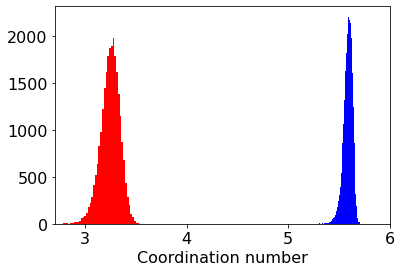

In [75]:
plt.hist(model.coordination_number(traj_center_train_hungarian), 50, color="blue")
plt.hist(model.coordination_number(traj_surface_train_hungarian), 50, color="red")
plt.xlabel("Coordination number")
plt.xlim(2.7, 6)
plt.savefig(results_dir + "training_dataset_CN_hist.png")

# Boltzmann generator

In [76]:
training_dataset = np.vstack([traj_center_train_hungarian, traj_surface_train_hungarian])
validation_dataset = np.vstack([traj_center_test_hungarian, traj_surface_test_hungarian])

In [77]:
print("Size of training dataset:", training_dataset.shape[0])
print("Size of validation dataset:", validation_dataset.shape[0])

Size of training dataset: 50000
Size of validation dataset: 50000


Functions to determine fraction of samples in $x$/$z$ with low energy.

In [78]:
def energy_cut_z(ndim, n_std=3):
    z = np.random.randn(10000, ndim)
    z_ener = 0.5 * np.sum(z**2, axis=1)
    std = np.sqrt(np.mean((z_ener - z_ener.mean())**2))
    # Mean energies of samples from z + n_std times their standard deviation
    return z_ener.mean() + n_std*std

def low_energy_fraction(energies, E_max):
    low_energy_count = [np.count_nonzero(E<E_max) for E in energies]
    total_size = [E.shape[0] for E in energies]
    low_energy_fraction = np.array(low_energy_count) / total_size
    return low_energy_fraction

## Set up the training

In [80]:
rc_loss_params = {
    'rc_function': model.coordination_number_tf,
    'rc_min': 3, 
    'rc_max': 5.8
}

In [81]:
save_dir_and_prefix = '../resources/bg_lj_cluster'
results_dir = '../results/lj_cluster'
z_low_limit = energy_cut_z(model.dim, n_std=2)
# RC entropy is calculated from histogram with 11 bins, see losses.py
max_rc_entropy = np.log(11)  

### Training script

In [88]:
# Script for plotting training info after each stage
def plot_convergence(loss_vals, x_energies, z_energies, rc_loss_weight, save_as=""):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for loss_name in ["loss", "val_loss"]:
        axes[0].plot(loss_vals[loss_name], label=loss_name)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend(loc='upper right')
        
    line1, = axes[1].plot(low_energy_fraction(z_energies, E_max=z_low_limit)*100, label="$z$")
    line2, = axes[1].plot(low_energy_fraction(x_energies, E_max=-110)*100, label="$x$")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("% of samples with $E < E_{low}$")
    axes[1].set_ylim(-5, 105)
    
    rc_axis = axes[1].twinx()
    rc_loss = loss_vals.get('RC_loss', np.array([]))
    line3, = rc_axis.plot(-rc_loss/rc_loss_weight/max_rc_entropy, color='green', label="$H_{RC}$")
    rc_axis.yaxis.tick_right()
    rc_axis.set_ylim(-0.05,1.05)
    rc_axis.yaxis.set_label_position('right')
    rc_axis.set_ylabel("RC entropy / max possible")
    rc_axis.legend(loc='lower right', handles=[line1, line2, line3])

    plt.subplots_adjust(wspace=0.3)
    if save_as:
        plt.savefig(save_as)
    plt.show()

    
# Training script
def train_bg(bg, training_schedule, save_from_stage=3, save_as=""):
    for i, args in enumerate(training_schedule):
        response = input("Should training continue? (press Enter)")
        if response == 'n':
            break
            
        current_loss_vals, x_energies, z_energies = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            high_energy = args[6],
            print_total_loss_only = False,
            print_training_info_interval = 20,
            return_validation_energies = True,
            **rc_loss_params
        )
        if i + 1 >= save_from_stage:
            bg.save(save_dir_and_prefix + '/bg_model')
        
        if save_as:
            file_name = results_dir + save_as + f"_{i+1}.png"
        else:
            file_name = ""
        
        plot_convergence(current_loss_vals, x_energies, z_energies, rc_loss_weight=args[2], save_as=file_name)

## Construct the BG

In [90]:
bg = BoltzmannGenerator(
    'R' * 8,
    model,
    nl_layers=5,
    nl_hidden=200
)

Layers of invertible NN: <RRRRRRRR>
< 14 0 0
R 7 7 0
R 7 7 0
R 7 7 0
R 7 7 0
R 7 7 0
R 7 7 0
R 7 7 0
R 7 7 0
> 7 7 0


In [91]:
bg.FzxJ.summary()

Model: "FzxJ"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
index_layer_11 (IndexLayer)     (None, 7)            0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_498 (Dense)               (None, 200)          1600        index_layer_11[0][0]             
__________________________________________________________________________________________________
dense_492 (Dense)               (None, 200)          1600        index_layer_11[0][0]             
_______________________________________________________________________________________________

In [92]:
# Load BG if it's already trained.
# bg.load(save_dir_and_prefix + '/bg_model-1')

## Training

In [93]:
training_schedule = [
#    w_ML, w_KL,  w_RC, iter, b_size,  lr,  E_high  
    [   1,     0,    0,  20,   2000,  1e-3,   1e4],
    [ 100,  0.01,   50, 200,   4000,  1e-4,   1e4],
    [ 100,   0.1,  100, 200,   4000,  1e-4,   5e3],
    [  30,     3,  100, 200,   4000,  1e-4,   1e3],
    [  20,    10,  130, 600,   4000,  1e-4,   1e3],
]

Should training continue? (press Enter)
Iteration 0/20: loss: 3.90 val_loss: 0.57 ML_loss: 3.90 val_ML_loss: 0.57 


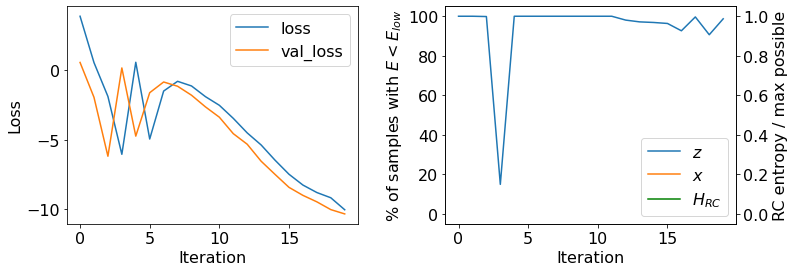

Should training continue? (press Enter)
Iteration 0/200: loss: -1088.90 val_loss: -1133.51 ML_loss: -1042.09 val_ML_loss: -1085.43 KL_loss: 68.21 val_KL_loss: 66.93 RC_loss: -115.02 val_RC_loss: -115.02 
Iteration 20/200: loss: -1473.94 val_loss: -1476.15 ML_loss: -1402.34 val_ML_loss: -1405.20 KL_loss: 43.91 val_KL_loss: 44.37 RC_loss: -115.52 val_RC_loss: -115.32 
Iteration 40/200: loss: -1812.93 val_loss: -1820.44 ML_loss: -1738.57 val_ML_loss: -1744.28 KL_loss: 42.08 val_KL_loss: 40.32 RC_loss: -116.44 val_RC_loss: -116.47 
Iteration 60/200: loss: -2102.46 val_loss: -2116.89 ML_loss: -2023.16 val_ML_loss: -2036.35 KL_loss: 35.90 val_KL_loss: 34.08 RC_loss: -115.20 val_RC_loss: -114.62 
Iteration 80/200: loss: -2311.35 val_loss: -2296.03 ML_loss: -2225.66 val_ML_loss: -2212.57 KL_loss: 26.83 val_KL_loss: 28.83 RC_loss: -112.51 val_RC_loss: -112.30 
Iteration 100/200: loss: -2449.83 val_loss: -2462.82 ML_loss: -2362.88 val_ML_loss: -2376.42 KL_loss: 23.41 val_KL_loss: 23.55 RC_loss: 

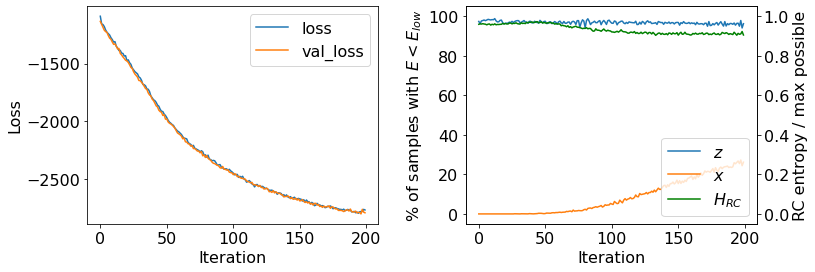

Should training continue? (press Enter)
Iteration 0/200: loss: -2858.14 val_loss: -2842.16 ML_loss: -2709.11 val_ML_loss: -2689.49 KL_loss: 70.41 val_KL_loss: 68.23 RC_loss: -219.43 val_RC_loss: -220.91 
Iteration 20/200: loss: -2873.21 val_loss: -2859.81 ML_loss: -2687.64 val_ML_loss: -2683.06 KL_loss: 36.37 val_KL_loss: 43.45 RC_loss: -221.94 val_RC_loss: -220.20 
Iteration 40/200: loss: -2912.27 val_loss: -2926.25 ML_loss: -2716.60 val_ML_loss: -2733.92 KL_loss: 24.59 val_KL_loss: 27.56 RC_loss: -220.25 val_RC_loss: -219.89 
Iteration 60/200: loss: -2949.42 val_loss: -2956.43 ML_loss: -2751.51 val_ML_loss: -2759.14 KL_loss: 24.96 val_KL_loss: 24.26 RC_loss: -222.86 val_RC_loss: -221.56 
Iteration 80/200: loss: -2986.68 val_loss: -2972.96 ML_loss: -2783.55 val_ML_loss: -2769.90 KL_loss: 17.86 val_KL_loss: 17.61 RC_loss: -220.99 val_RC_loss: -220.67 
Iteration 100/200: loss: -2998.61 val_loss: -2979.50 ML_loss: -2790.32 val_ML_loss: -2770.09 KL_loss: 13.27 val_KL_loss: 12.50 RC_loss: 

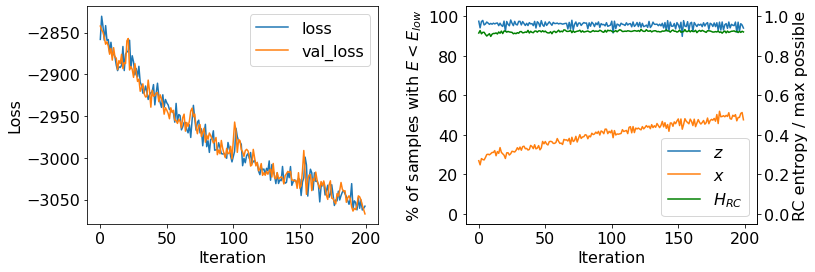

Should training continue? (press Enter)
Iteration 0/200: loss: -1095.20 val_loss: -1132.90 ML_loss: -856.42 val_ML_loss: -838.27 KL_loss: -17.52 val_KL_loss: -74.39 RC_loss: -221.26 val_RC_loss: -220.24 
Iteration 20/200: loss: -1231.71 val_loss: -1231.65 ML_loss: -836.45 val_ML_loss: -835.10 KL_loss: -180.81 val_KL_loss: -182.95 RC_loss: -214.44 val_RC_loss: -213.59 
Iteration 40/200: loss: -1252.76 val_loss: -1256.10 ML_loss: -839.96 val_ML_loss: -836.98 KL_loss: -195.00 val_KL_loss: -201.78 RC_loss: -217.80 val_RC_loss: -217.34 
Iteration 60/200: loss: -1265.38 val_loss: -1267.22 ML_loss: -846.45 val_ML_loss: -844.96 KL_loss: -200.04 val_KL_loss: -203.00 RC_loss: -218.89 val_RC_loss: -219.26 
Iteration 80/200: loss: -1278.38 val_loss: -1275.25 ML_loss: -852.77 val_ML_loss: -849.43 KL_loss: -207.19 val_KL_loss: -207.37 RC_loss: -218.43 val_RC_loss: -218.44 
Iteration 100/200: loss: -1283.44 val_loss: -1278.48 ML_loss: -854.93 val_ML_loss: -851.47 KL_loss: -210.05 val_KL_loss: -208.22

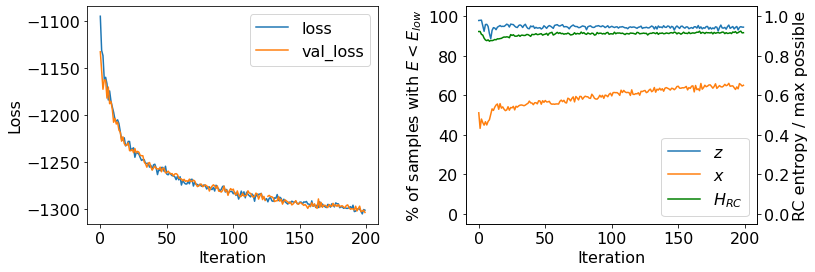

Should training continue? (press Enter)
Iteration 0/600: loss: -1589.70 val_loss: -1582.69 ML_loss: -577.99 val_ML_loss: -573.80 KL_loss: -725.65 val_KL_loss: -723.03 RC_loss: -286.07 val_RC_loss: -285.86 
Iteration 20/600: loss: -1596.67 val_loss: -1597.24 ML_loss: -572.71 val_ML_loss: -572.79 KL_loss: -743.01 val_KL_loss: -745.81 RC_loss: -280.95 val_RC_loss: -278.64 
Iteration 40/600: loss: -1602.87 val_loss: -1604.94 ML_loss: -573.93 val_ML_loss: -575.00 KL_loss: -752.08 val_KL_loss: -752.64 RC_loss: -276.87 val_RC_loss: -277.30 
Iteration 60/600: loss: -1603.18 val_loss: -1605.35 ML_loss: -571.38 val_ML_loss: -571.69 KL_loss: -755.54 val_KL_loss: -757.78 RC_loss: -276.26 val_RC_loss: -275.89 
Iteration 80/600: loss: -1613.59 val_loss: -1613.04 ML_loss: -577.54 val_ML_loss: -576.39 KL_loss: -760.50 val_KL_loss: -760.70 RC_loss: -275.56 val_RC_loss: -275.94 
Iteration 100/600: loss: -1615.79 val_loss: -1612.62 ML_loss: -579.35 val_ML_loss: -574.57 KL_loss: -761.02 val_KL_loss: -761.

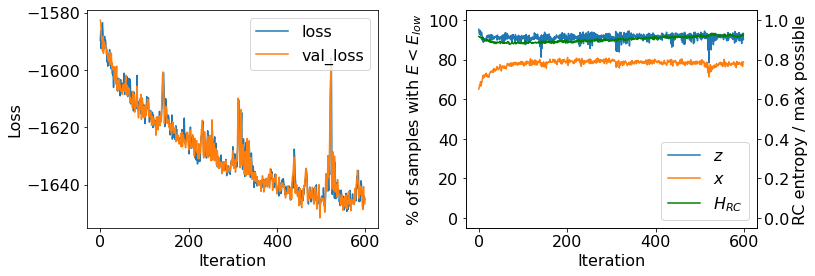

In [94]:
train_bg(bg, training_schedule, save_from_stage=3, save_as="training_stats")

In [99]:
# Save the BG
# bg.save(save_dir_and_prefix + '/bg_model')

In [95]:
_, sample_x, _, energies_x, _ = bg.sample(n_sample=100000)

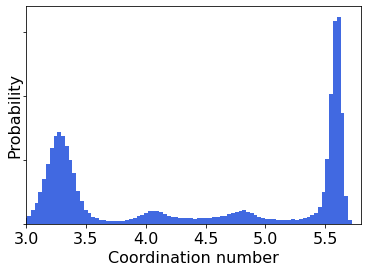

In [105]:
plt.hist(model.coordination_number(sample_x), 100, density=True, color="royalblue")
plt.xlim(3, 5.8)
plt.xlabel("Coordination number")
plt.tick_params(labelleft=False)
plt.ylabel("Probability")
plt.savefig(results_dir + "CN_histogram.png")

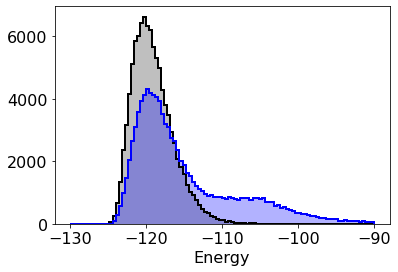

In [120]:
kwargs = {"bins": 100, "range": (-130, -90)}
plt.hist(model.energy(training_dataset), **kwargs, color="black", histtype="step", linewidth=2,
         weights=2*np.ones(50000))
plt.hist(model.energy(training_dataset), **kwargs, color="gray", alpha=0.5, weights=2*np.ones(50000))

plt.hist(energies_x, **kwargs, color="blue", histtype="step", linewidth=2)
plt.hist(energies_x, **kwargs, color="blue", alpha=0.3)

plt.xlabel("Energy")
plt.savefig(results_dir + "energy_histogram.png")

<AxesSubplot:>

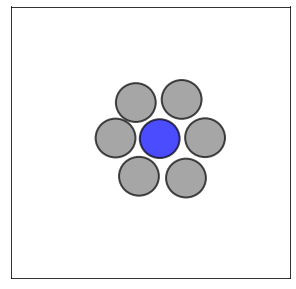

In [121]:
# Show random configuration sampled from the BG
model.draw_config(sample_x[np.random.randint(0, 10000)], particle_colors={1: "blue"})

### Explore the latent interpolations

In [122]:
def latent_interpolation(bg, x1, x2, n_step=200, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=n_step)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        z_path_1 = z1 * (1-lambdas[::2])
        z_path_2 = z2 * (lambdas[::2]) 
        z_path = np.vstack([zpath1, zpath2])
    else:
        z_path = z1 + lambdas*(z2 - z1)
    x_path = bg.transform_zx(z_path)
    return x_path

In [289]:
def interpolate(i, j, n_step):
    path = latent_interpolation(
        bg, 
        traj_center_train_hungarian[i*500],
        traj_surface_train_hungarian[j*500],
#         traj_surface_train_3_hungarian[j*160], 
        n_step=n_step
    )
    E = model.energy(path).max()
    return path, E

In [290]:
# Try to find minimum energy path
N = 50

E_min = 1e9
best_path = None
transition_energies = []

E_low = -95
E_low_paths = []

for i in range(N):
    if i % 10 == 0:
        print("i =", i)
    for j in range(N):
        path, E = interpolate(i, j, 200)
        transition_energies.append(E)
        
        if E < E_low:
            path, E = interpolate(i, j, 1000)
            if E < E_low:
                E_low_paths.append(path)
        
        if E < E_min:
            E_min = E
            best_path = path
            
E_low_paths = np.array(E_low_paths)
print("E_min:", E_min)

i = 0
i = 10
i = 20
i = 30
i = 40
E_min: 1000000000.0


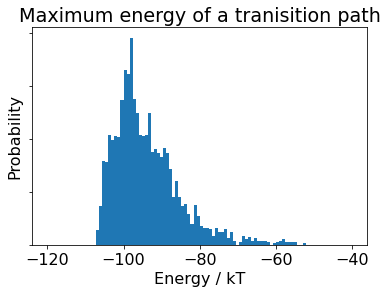

In [293]:
plt.figure(figsize=(6, 4))
plt.hist(transition_energies, 100, (-120, -40), density=True)
plt.title("Maximum energy of a tranisition path")
plt.xlabel("Energy / kT")
plt.tick_params(labelleft=False)
plt.ylabel("Probability", labelpad=10)
plt.savefig(results_dir + "transition_path_energies.png")

In [244]:
# E_low_paths.shape

(1969, 1000, 14)

In [280]:
# best_path = E_low_paths[1000]

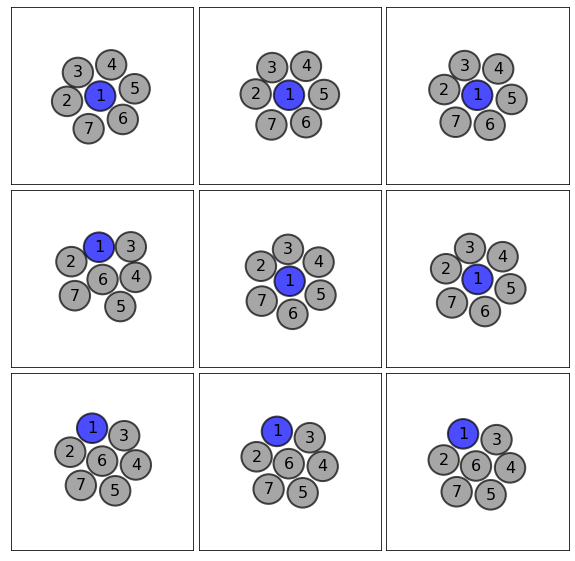

In [281]:
# Show the best path
step = 100
shift = 100
draw_params = {"particle_colors": {1: "blue"}, "with_numbers": True, "box_size": 6}
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

model.draw_config(best_path[0*step + shift], axis=axes[0, 0], **draw_params)
model.draw_config(best_path[1*step + shift], axis=axes[0, 1], **draw_params)
model.draw_config(best_path[2*step + shift], axis=axes[0, 2], **draw_params)

model.draw_config(best_path[3*step + shift], axis=axes[1, 2], **draw_params)
model.draw_config(best_path[4*step + shift], axis=axes[1, 1], **draw_params)
model.draw_config(best_path[5*step + shift], axis=axes[1, 0], **draw_params)

model.draw_config(best_path[6*step + shift], axis=axes[2, 0], **draw_params)
model.draw_config(best_path[7*step + shift], axis=axes[2, 1], **draw_params)
model.draw_config(best_path[8*step + shift], axis=axes[2, 2], **draw_params)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

# plt.savefig(results_dir + "transition_mechanism_3.png")

Max energy: -102.44652


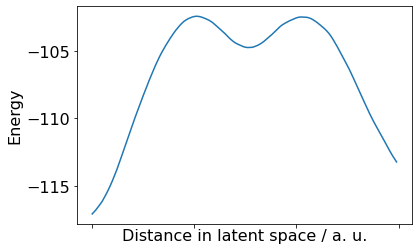

In [254]:
x1 = best_path[615]
x2 = best_path[647]
path = latent_interpolation(bg, x1, x2, n_step=150)
path_energy = model.energy(path)
print("Max energy:", path_energy.max())

plt.plot(path_energy)
plt.tick_params(labelbottom=False)
plt.xlabel("Distance in latent space / a. u.")
plt.ylabel("Energy")
plt.savefig(results_dir + "energy_profile_tm_3.png")

In [255]:
%%capture
# Create animation of transition
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
for i, x in enumerate(path):
    model.draw_config(x, axis=axis, particle_colors={1: "blue"}, box_size=9)
    axis.text(
        2.8, 3, f"{path_energy[i]:.1f}", fontsize=32,
        horizontalalignment='center', verticalalignment='center',
    )
    fig.savefig(f'../results/lj_cluster/transition_animation/frame_{i:03}.png', 
                format='png')
    if i != 149:
        flush = plt.cla()

## Compute free-energy profile using BG

In [282]:
_, sample_x, _, _, sample_logw = bg.sample(300000)
coordination_numbers = model.coordination_number(sample_x)

In [284]:
# us_free_energy = 0.5 * (umbrella_free_energy[:60] + umbrella_free_energy[60:])
# us_free_energy = us_free_energy - us_free_energy.min()
# us_positions = umbrella_positions[:70]

us_free_energy = mbar_free_energy - mbar_free_energy.min()
us_positions = mbar_positions

In [285]:
bin_values, Fs = free_energy_bootstrap(
    coordination_numbers, 
    50, 
    (2.7, 6), 
    log_weights=sample_logw, 
    n_bootstrap=3000
)
F_calc = mean_finite(Fs, axis=0)
F_calc_error = std_finite(Fs, axis=0)

../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


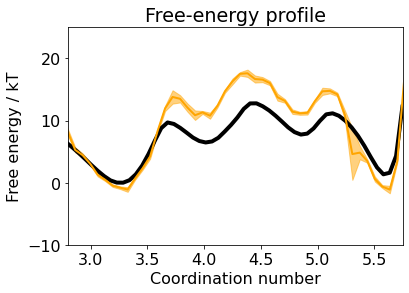

In [288]:
plt.figure(figsize=(6, 4))

plt.plot(us_positions, us_free_energy, color='black', linewidth=4)
plt.plot(bin_values, F_calc, color='orange', linewidth=2)
plt.fill_between(bin_values, F_calc-F_calc_error, F_calc+F_calc_error, color='orange', alpha=0.5)
plt.xlim(2.8, 5.75)
plt.ylim(-10, 25)
plt.xlabel('Coordination number')
plt.ylabel('Free energy / kT', labelpad=5)
plt.title("Free-energy profile")
plt.savefig(results_dir + '/free_energy_profile.png')